# Measuring Risk: Dynamic Risk Assessment and Analysis in Python

This example relies on `riskfolio-lib` to calculate various risk measures from Yahoo Finance data.

This code demonstrates how to:
- Download stock data using `yfinance`
- Calculate various risk measures using `riskfolio-lib`
- Create rolling risk measures to  assess the dynamics of risk over time
- Visualize the results

## Import necessary libraries
Use below to install libraries if missing:
```python
!pip instal library_nameE
```

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Define helper functions

In [3]:
def download_stock_data(tickers, start_date, end_date):
    """
    Download stock data from Yahoo Finance
    """
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock['Adj Close']
    return data

def calculate_returns(prices):
    """
    Calculate logarithmic returns
    """
    return np.log(prices/prices.shift(1)).dropna()

def calculate_portfolio_returns(returns, weights=None):
    """
    Calculate portfolio returns based on weights
    
    Parameters:
    returns (pd.DataFrame): Asset returns
    weights (dict or np.array): Asset weights. If None, equal weights are used
    
    Returns:
    pd.Series: Portfolio returns
    dict: Weights used
    """
    n_assets = returns.shape[1]
    
    # Handle weights input
    if weights is None:
        # Equal weights
        weights_dict = {col: 1/n_assets for col in returns.columns}
    elif isinstance(weights, dict):
        # Check if weights are provided for all assets
        if not all(col in weights for col in returns.columns):
            raise ValueError("Weights must be provided for all assets")
        weights_dict = weights
    else:
        # Convert array-like weights to dictionary
        if len(weights) != n_assets:
            raise ValueError("Number of weights must match number of assets")
        weights_dict = dict(zip(returns.columns, weights))
    
    # Convert weights to array for calculations
    weights_array = np.array([weights_dict[col] for col in returns.columns])
    
    # Calculate portfolio returns
    portfolio_returns = returns.mul(weights_array).sum(axis=1)
    
    return portfolio_returns, weights_dict

## Define main functions for this example

You can easily infer that the risk measures are calculated from `riskfolio-lib` package using:
```python
rp.RiskFunctions.VaR_Hist(ret, alpha)
```

For the list of available risk measures, you can check Riskfolio-Lib documentation [here](https://riskfolio-lib.readthedocs.io/en/latest/risk.html).


In [6]:
def calculate_risk_measures(portfolio_returns, confidence_level=0.95):
    """
    Calculate various risk measures for the portfolio
    
    Parameters:
    portfolio_returns (pd.Series): Portfolio returns
    confidence_level (float): Confidence level for VaR and CVaR
    
    Returns:
    pd.Series: Risk measures
    """
    # Convert to DataFrame for riskfolio functions
    returns_df = portfolio_returns.to_frame('Portfolio')
    w = np.array([1.0])  # Single weight for portfolio
    
    risk_metrics = {}
    
    # Historical VaR and CVaR
    risk_metrics['Historical VaR'] = rp.RiskFunctions.VaR_Hist(returns_df, alpha=1-confidence_level)
    risk_metrics['Historical CVaR'] = rp.RiskFunctions.CVaR_Hist(returns_df, alpha=1-confidence_level)
    
    # Other risk measures
    risk_metrics['Semi Deviation'] = rp.RiskFunctions.SemiDeviation(returns_df)
    risk_metrics['MAD'] = rp.RiskFunctions.MAD(returns_df)
    risk_metrics['GMD'] = rp.RiskFunctions.GMD(returns_df)
    
    # Maximum Drawdown measures
    risk_metrics['Max Drawdown (Abs)'] = rp.RiskFunctions.MDD_Abs(returns_df)
    risk_metrics['Max Drawdown (Rel)'] = rp.RiskFunctions.MDD_Rel(returns_df)
    
    # Additional measures
    risk_metrics['Entropic Risk Measure'] = rp.RiskFunctions.Entropic_RM(returns_df)
    
    return pd.Series(risk_metrics, name='Risk Measure')

def calculate_rolling_risk(portfolio_returns, window=252, confidence_level=0.95):
    """
    Calculate rolling risk measures
    
    Parameters:
    portfolio_returns (pd.Series): Portfolio returns
    window (int): Rolling window size
    confidence_level (float): Confidence level for VaR and CVaR
    
    Returns:
    pd.DataFrame: Rolling risk measures
    """
    rolling_metrics = pd.DataFrame(index=portfolio_returns.index[window-1:],
                                 columns=['VaR', 'CVaR', 'Volatility'])
    
    for i in range(window-1, len(portfolio_returns)):
        window_returns = portfolio_returns.iloc[i-window+1:i+1]
        window_returns_df = window_returns.to_frame('Portfolio')
        w = np.array([1.0])
        
        # Calculate VaR and CVaR
        rolling_metrics.iloc[i-window+1, 0] = rp.RiskFunctions.VaR_Hist(window_returns_df, alpha=1-confidence_level)
        rolling_metrics.iloc[i-window+1, 1] = rp.RiskFunctions.CVaR_Hist(window_returns_df, alpha=1-confidence_level)
        
        # Calculate annualized volatility
        rolling_metrics.iloc[i-window+1, 2] = window_returns.std() * np.sqrt(252)
    
    return rolling_metrics

## Define plotting functions

In [9]:
def plot_risk_metrics(risk_metrics, title):
    """
    Create a bar plot of risk metrics
    """
    plt.figure(figsize=(12, 6))
    risk_metrics.plot(kind='bar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel('Risk Measure')
    plt.tight_layout()
    plt.show()

def plot_rolling_risks(rolling_metrics, confidence_level):
    """
    Plot rolling risk measures
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot VaR
    rolling_metrics['VaR'].plot(ax=axes[0])
    axes[0].set_title(f'Rolling VaR ({confidence_level*100}% confidence level)')
    axes[0].set_xlabel('')
    
    # Plot CVaR
    rolling_metrics['CVaR'].plot(ax=axes[1])
    axes[1].set_title(f'Rolling CVaR ({confidence_level*100}% confidence level)')
    axes[1].set_xlabel('')
    
    # Plot Volatility
    rolling_metrics['Volatility'].plot(ax=axes[2])
    axes[2].set_title('Rolling Annualized Volatility')
    
    plt.tight_layout()
    plt.show()

## Download data and construct a portfolio

In [14]:
# Define parameters
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3)  # 3 years of data

confidence_level = 0.95 # define a confidence value for tail risk measures

In [16]:
# Example custom weights (optional)
custom_weights = {
        'AAPL': 0.3,
        'MSFT': 0.25,
        'GOOGL': 0.2,
        'AMZN': 0.15,
        'META': 0.1
    }

In [18]:
# Download and prepare data
print("Downloading stock data...")
prices = download_stock_data(tickers, start_date, end_date)
returns = calculate_returns(prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [22]:
# Calculate portfolio returns (using equal weights as default)

portfolio_returns, weights = calculate_portfolio_returns(returns)                  # Uses default weights (equal)
#portfolio_returns, weights = calculate_portfolio_returns(returns, custom_weights) # Custom weights defined above
print("\nPortfolio Weights:")
for asset, weight in weights.items():
    print(f"{asset}: {weight:.2%}")


Portfolio Weights:
AAPL: 20.00%
MSFT: 20.00%
GOOGL: 20.00%
AMZN: 20.00%
META: 20.00%


## Quick example: calculate risk measures

In [31]:
rp.RiskFunctions.VaR_Hist(portfolio_returns, alpha=0.05)

0.030675435728284496

In [27]:
rp.RiskFunctions.VaR_Hist(portfolio_returns, alpha=0.01)

0.04977851905175877

In [29]:
rp.RiskFunctions.CVaR_Hist(portfolio_returns) # default alpha is 0.05 

0.04303621189061961

## Calculate risk measures defined in our earlier function

In [34]:
# Calculate risk measures
print("\nCalculating risk measures...")
risk_metrics = calculate_risk_measures(portfolio_returns, confidence_level)


Calculating risk measures...


In [36]:
# Calculate rolling measures
print("\nCalculating rolling risk measures...")
rolling_metrics = calculate_rolling_risk(portfolio_returns, 
                                          window=252, 
                                          confidence_level=confidence_level)


Calculating rolling risk measures...


## Print and plot the results


Risk Metrics Summary:
Historical VaR           0.0307
Historical CVaR          0.0430
Semi Deviation           0.0134
MAD                      0.0133
GMD                      0.0196
Max Drawdown (Abs)       0.6587
Max Drawdown (Rel)       0.5162
Entropic Risk Measure    2.9955
Name: Risk Measure, dtype: float64


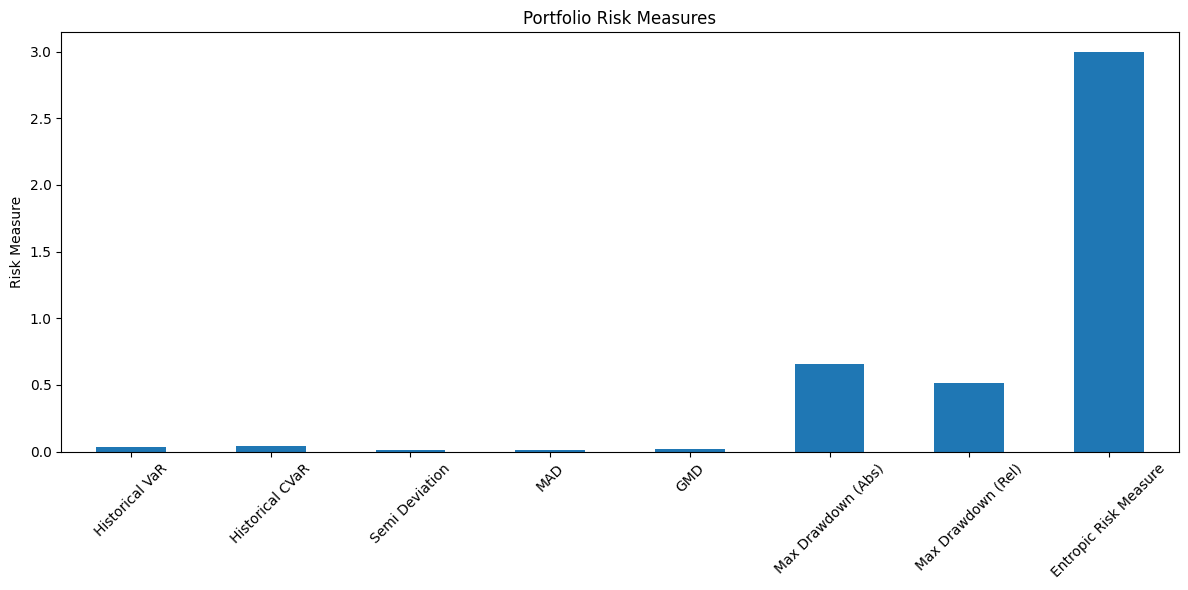

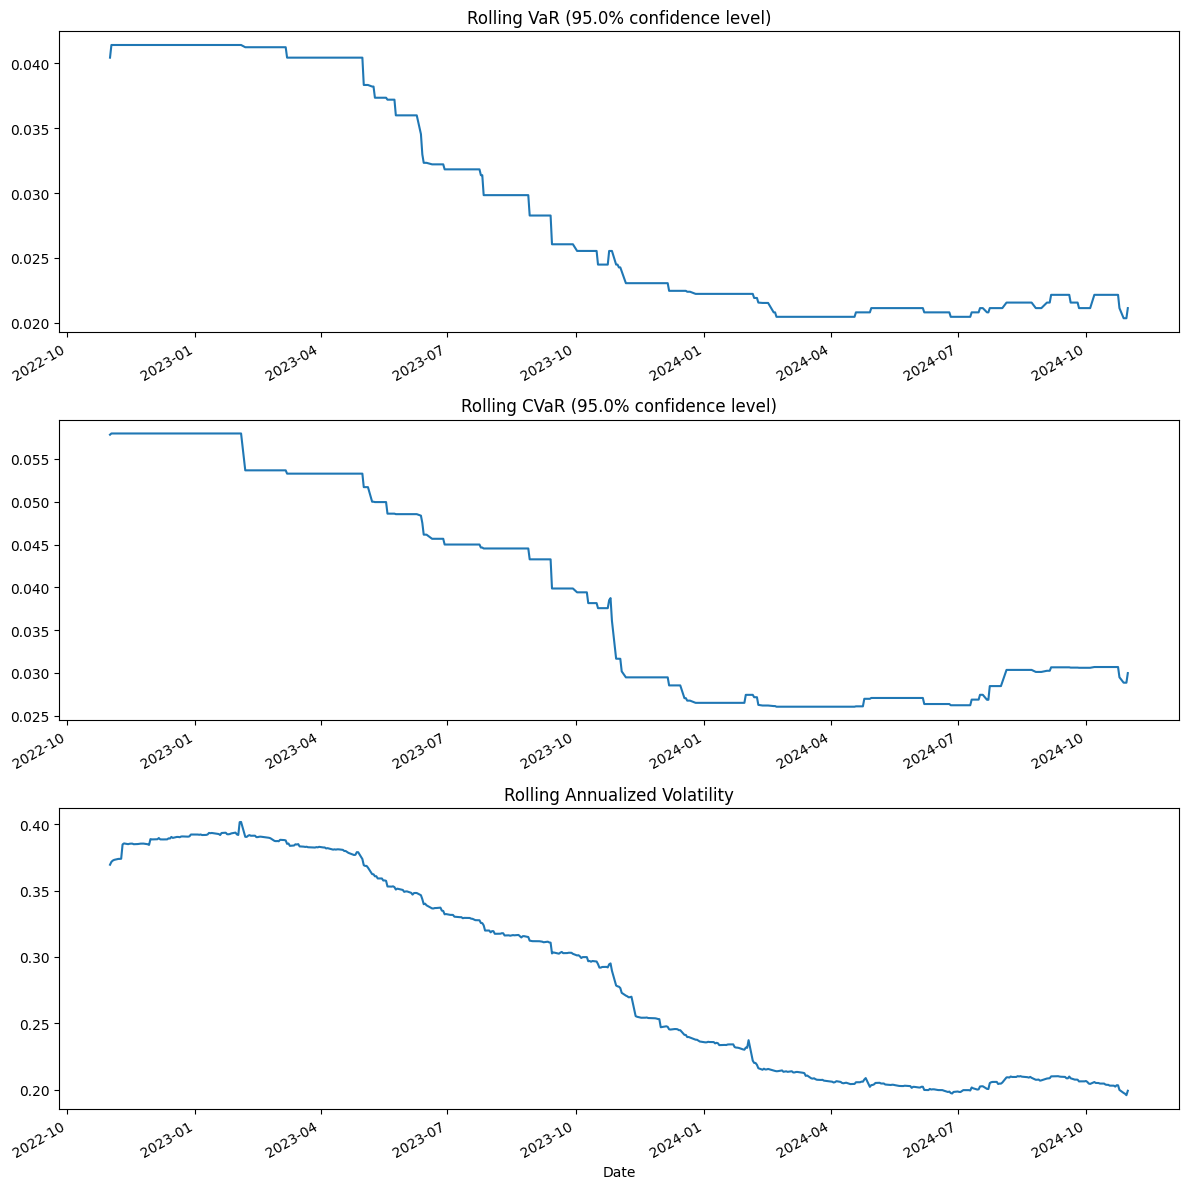


Calculating with custom weights...

Risk Metrics with Custom Weights:
Historical VaR           0.0289
Historical CVaR          0.0394
Semi Deviation           0.0124
MAD                      0.0126
GMD                      0.0185
Max Drawdown (Abs)       0.5395
Max Drawdown (Rel)       0.4493
Entropic Risk Measure    2.9955
Name: Risk Measure, dtype: float64


In [39]:
# Print results
print("\nRisk Metrics Summary:")
print(risk_metrics.round(4))
    
# Create visualizations
plot_risk_metrics(risk_metrics, "Portfolio Risk Measures")
plot_rolling_risks(rolling_metrics, confidence_level)

# Example with custom weights
print("\nCalculating with custom weights...")
portfolio_returns_custom, weights_custom = calculate_portfolio_returns(returns, custom_weights)
risk_metrics_custom = calculate_risk_measures(portfolio_returns_custom, confidence_level)
print("\nRisk Metrics with Custom Weights:")
print(risk_metrics_custom.round(4))